# 线性回归和梯度下降

## 准备阶段：生成训练数据和测试数据，选取多元一次的线性关系

In [13]:
# 生成train data和test data
# 随机选择一些x和w，b
from random import randint, uniform
from numpy import random


def genCase(n: int, m: int):
    x = random.uniform(-10, 10, (m, n))
    w = random.uniform(0, 10, (n, 1))
    b = uniform(0, 10)
    # 加入噪音
    y = [sum(x[i1].dot(w)) + b + uniform(-0.5, 0.5) for i1 in range(len(x))]
    print("Generated %d cases with %d features." % (m, n))
    return x, y, w, b


def splitCase(x, y):
    n = len(x)
    if len(y) != n:
        return [], [], [], []
    trainX, trainY, testX, testY = [], [], [], []
    for j1 in range(n):
        if randint(1, 4) > 2:
            testX.append(x[j1])
            testY.append(y[j1])
        else:
            trainX.append(x[j1])
            trainY.append(y[j1])
    print("Split data into 2 parts: %d train data and %d test data" % (len(trainX), len(testX)))
    return trainX, trainY, testX, testY


X, Y, OriginW, OriginB = genCase(10, 1000)
TrainX, TrainY, TestX, TestY = splitCase(X, Y)
# 导出到文件
with open('./data/train.txt', 'w') as f:
    for i in range(len(TrainX)):
        f.write('\t'.join(list(map(str, TrainX[i]))) + '\t' + str(TrainY[i]) + '\n')
with open('./data/test.txt', 'w') as f:
    for i in range(len(TestX)):
        f.write('\t'.join(list(map(str, TestX[i]))) + '\t' + str(TestY[i]) + '\n')

Generated 1000 cases with 10 features.
Split data into 2 parts: 515 train data and 485 test data


## 训练阶段：采用批量梯度下降方法拟合

In [14]:
from numpy import loadtxt, ones


def h(x, w, b):
    return sum(x.dot(w)) + b


def loss(x, y, w, b):
    return sum([(h(x[i1], w, b) - y[i1]) ** 2 for i1 in range(len(x))])


def batchGradientDescent(x, y, rate=0.1, iterBound=100000, gradBound=1e-6):
    m = len(x)
    if m == 0 or len(y) != m:
        return [], -1
    n = len(x[0])
    w, b = ones((n, 1)), 1
    print("Learning ratio: %f" % rate)
    for k in range(iterBound):
        gradW = [sum([x[i][j] * (y[i] - h(x[i], w, b)) for i in range(m)]) / m for j in range(n)]
        gradB = sum([(y[i] - h(x[i], w, b)) for i in range(m)]) / m
        # 跳出循环的条件：梯度值较小
        if abs(gradB) <= gradBound:
            print("Converges after %d rounds of batch gradient descent." % k)
            return w, b
        for i in range(n):
            w[i] += gradW[i] * rate
        b += gradB * rate
    print("After %d rounds of gradient descent, the loss is %f" % (k, loss(x, y, w, b)))
    return w, b


def readData(file: str):
    with open(file, 'r') as f:
        data = loadtxt(f)
    return [data[i1][:-1] for i1 in range(len(data))], [data[i1][-1] for i1 in range(len(data))]


trainX, trainY = readData("./data/train.txt")
testX, testY = readData("./data/test.txt")
%time W, B = batchGradientDescent(trainX, trainY, 0.02)

Learning ratio: 0.020000
Converges after 696 rounds of batch gradient descent.
CPU times: user 7.05 s, sys: 22 ms, total: 7.08 s
Wall time: 7.09 s


## 预测阶段：使用test数据测试模型准确率

In [15]:
print("Loss for test data: %f" % loss(testX, testY, W, B))
print("Loss for test data with original w and b: %f" % loss(testX, testY, OriginW, OriginB))
print("Difference for w and b:", OriginW - W, OriginB - B)

Loss for test data: 43.180648
Loss for test data with original w and b: 41.600574
Difference for w and b: [[ 0.00109262]
 [-0.00581631]
 [ 0.00122251]
 [-0.00210383]
 [-0.00198792]
 [-0.00037012]
 [ 0.00243138]
 [-0.004199  ]
 [-0.00064644]
 [ 0.00013948]] -0.009272296463247759


- 经过梯度下降之后，达到了较好的精度。
- 时间上存在改进空间。

## 自适应learning rate：Adagrad

In [22]:
from math import sqrt

def improvedBGD(x, y, iterBound=10000, gradBound=1e-6):
    m = len(x)
    if m == 0 or len(y) != m:
        return [], -1
    n = len(x[0])
    w, b = ones((n, 1)), 1
    rateW, rateB = [0 for _ in range(n)], 0
    for k1 in range(iterBound):
        gradW = [sum([x[i][j] * (y[i] - h(x[i], w, b)) for i in range(m)]) / m for j in range(n)]
        gradB = sum([(y[i] - h(x[i], w, b)) for i in range(m)]) / m
        # 跳出循环的条件：梯度值较小
        if abs(gradB) <= gradBound:
            print("Converges after %d rounds of batch gradient descent." % k1)
            return w, b
        for i in range(n):
            rateW[i] += gradW[i] ** 2
            w[i] += gradW[i] / sqrt(rateW[i])
        rateB += gradB ** 2
        b += gradB / sqrt(rateB)
    print("After %d rounds of gradient descent, the loss is %f" % (k1, loss(x, y, w, b)))
    return w, b

%time W, B = improvedBGD(trainX, trainY)
print("Loss for test data: %f" % loss(testX, testY, W, B))
print("Loss for test data with original w and b: %f" % loss(testX, testY, OriginW, OriginB))
print("Difference for w and b:", OriginW - W, OriginB - B)

Converges after 251 rounds of batch gradient descent.
CPU times: user 2.55 s, sys: 9.66 ms, total: 2.56 s
Wall time: 2.57 s
Loss for test data: 43.177537
Loss for test data with original w and b: 41.600574
Difference for w and b: [[ 0.00108563]
 [-0.00580816]
 [ 0.00122102]
 [-0.002008  ]
 [-0.00198998]
 [-0.0003545 ]
 [ 0.00242942]
 [-0.00419475]
 [-0.00064363]
 [ 0.00016461]] -0.009286649191009438


- 可以看到，时间和精度上都更合理，自动调整学习率能够避免不收敛或者收敛过慢的问题。

## 使用高次拟合，查看loss变化

In [23]:
def generateAll(x, n):
    if n == 1:
        return x
    res = ones((len(x), n * len(x[0])))
    count = len(x[0])
    for i1 in range(len(x)):
        for j1 in range(n):
            for k1 in range(count):
                res[i1][k1 + j1 * count] = x[i1][k1] ** (j1 + 1)
    return res


# 拟合过程可以直接使用batchGradientDescent函数解决
# 为了节约时间（一方面learning rate不能高，一高就不收敛；另一方面太低可能半小时都跑不出来）
trainLoss = [loss(trainX, trainY, W, B)]
testLoss = [loss(testX, testY, W, B)]
for i in range(2, 6):
    exTrainX, exTestX = generateAll(trainX, i), generateAll(testX, i)
    %time Wi, Bi = improvedBGD(exTrainX, trainY)
    trainLoss.append(loss(exTrainX, trainY, Wi, Bi))
    testLoss.append(loss(exTestX, testY, Wi, Bi))

After 9999 rounds of gradient descent, the loss is 36.904122
CPU times: user 3min 50s, sys: 1.34 s, total: 3min 51s
Wall time: 3min 52s
After 9999 rounds of gradient descent, the loss is 35.874497
CPU times: user 5min 39s, sys: 1.56 s, total: 5min 40s
Wall time: 5min 42s
After 9999 rounds of gradient descent, the loss is 261.607271
CPU times: user 7min 28s, sys: 2.38 s, total: 7min 31s
Wall time: 7min 33s
After 9999 rounds of gradient descent, the loss is 181030.524181
CPU times: user 9min 20s, sys: 3.25 s, total: 9min 24s
Wall time: 9min 27s


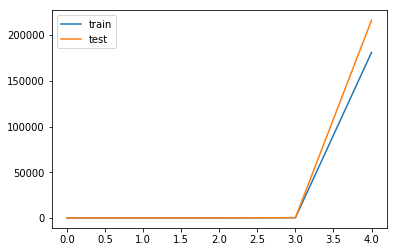

In [25]:
import matplotlib.pyplot as plt
from numpy import arange

x_axis = arange(len(trainLoss))
plt.axis('on')
plt.plot(x_axis, trainLoss, label='train')
plt.plot(x_axis, testLoss, label='test')
plt.legend()
plt.show()

- 出现了明显的overfitting现象

In [27]:
print(testLoss)

[43.17753677246426, 46.221044463400624, 47.5150256435928, 295.13051190429354, 216220.90071215943]
